In [1]:
import ee
import numpy as np
from osgeo import gdal
from osgeo import osr
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd
import seaborn as sns
from scipy import stats
import folium
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
from matplotlib import rcParams
import matplotlib.cm as cm # matplotlib's color map library
import warnings
from matplotlib.ticker import FuncFormatter
from matplotlib import gridspec
import seaborn as sns
import ipywidgets

warnings.filterwarnings("ignore")

# init the ee object
ee.Initialize()

C:\Users\owner\anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  from ipykernel import kernelapp as app


In [2]:
# https://www.techforwildlife.com/blog/2019/1/22/analysing-drone-and-satellite-imagery-using-vegetation-indices
def p2r(point, area_size = 500):
    dist_lat = abs(area_size / 110.540)/1000
    dist_lon = abs(area_size / (111.320 * np.cos(point[0])))/1000
    area = {"type": "FeatureCollection", "features": [{"type": "Feature", "properties": {},"geometry": {"type": "Polygon", "coordinates": [[[point[0] - dist_lon/2, point[1] - dist_lat/2], [point[0] + dist_lon/2, point[1] - dist_lat/2], [point[0] + dist_lon/2, point[1] + dist_lat/2], [point[0] - dist_lon/2, point[1] + dist_lat/2], [point[0] - dist_lon/2, point[1] - dist_lat/2]]]}}]}
    coords_area = area['features'][0]['geometry']['coordinates']
    aoi_area = ee.Geometry.Polygon(coords_area)
    return area, aoi_area
    
def contour_plt(df, no_con):
    Z = df.pivot_table(index='X', columns='Y', values='Z').T.values

    X_unique = np.sort(df.X.unique())
    Y_unique = np.sort(df.Y.unique())
    X, Y = np.meshgrid(X_unique, Y_unique)

    # Initialize plot objects
    rcParams['figure.figsize'] = 5, 5 # sets plot size
    fig = plt.figure()
    ax = fig.add_subplot(111)
    levels = np.linspace(np.min(df['Z']), np.max(df['Z']), no_con)

    cpf = ax.contourf(X, Y, Z, len(levels), cmap = cm.Reds)
    line_colors = ['black' for l in cpf.levels]
    cp = ax.contour(X, Y, Z, levels=levels, colors=line_colors)
    ax.clabel(cp, fontsize=10, colors=line_colors)
    plt.xticks()
    plt.yticks()
    ax.set_xlabel('X-axis')
    _ = ax.set_ylabel('Y-axis')
    plt.grid()

global area_x, area_y

def format_xtick_labels(x, pos): return '{0:.3f}$^\circ$N'.format(x)
def format_ytick_labels(x, pos): return '{0:.3f}$^\circ$E'.format(x)

def contour_plt(water_level):
    no_con = 6
    img1 = ee.Image('USGS/SRTMGL1_003').select(['elevation'])
    new=img1.toArray().toArray(1)

    band_arrs = img1.sampleRectangle(region=area)
    band_arr_b2 = band_arrs.get('elevation')
    np_arr_b2 = np.array(band_arr_b2.getInfo())
    
    latlon = ee.Image.pixelLonLat().addBands(img1)
    latlon = latlon.reduceRegion(
      reducer=ee.Reducer.toList(),
      geometry=area,
      scale=100);
    lats = np.array((ee.Array(latlon.get("latitude")).getInfo()))
    lons = np.array((ee.Array(latlon.get("longitude")).getInfo()))
    # long is x and lat is y
    df = pd.DataFrame(np_arr_b2).unstack().reset_index()
    df.columns = ["X","Y","Z"]

    df['X'] = pd.Categorical(df['X'])
    df['X'] = df['X'].cat.codes
    xmax2, xmin2, ymax2, ymin2 = lons.max(), lons.min(), lats.max(), lats.min()
    df['X'] = np.interp(df['X'], (df['X'].min(), df['X'].max()), (xmin2, xmax2))
    df['Y'] = np.interp(df['Y'], (df['Y'].min(), df['Y'].max()), (ymin2, ymax2))
    Z = df.pivot_table(index='X', columns='Y', values='Z').T.values
    X_unique = np.sort(df.X.unique())
    Y_unique = np.sort(df.Y.unique())
    X, Y = np.meshgrid(X_unique, Y_unique)
    rcParams['figure.figsize'] = 5, 5 # sets plot size
    
    fig, [ax, ax2] = plt.subplots(1, 2, figsize = (12, 6))
    gs = gridspec.GridSpec(1, 2, width_ratios=[2.5, 1])
    ax = plt.subplot(gs[0])
#     ax = fig.add_subplot(111)
    Z2 = np.where(Z < water_level, -9999, np.nan)
    levels = np.linspace(np.min(df['Z']), np.max(df['Z']), no_con)
    cpf = ax.contourf(X, Y, Z, len(levels), cmap = cm.Reds)
    ax.contourf(X, Y, Z2, cmap = cm.Blues)
    line_colors = ['black' for l in cpf.levels]
    cp = ax.contour(X, Y, Z, levels=levels, colors=line_colors)
    ax.clabel(cp, fontsize=10, colors=line_colors)
    plt.xticks()
    plt.yticks()
    ax.set_xlabel('')
    _ = ax.set_ylabel('')
    plt.title('Water Level: {:.2f} m'.format(water_level))
    plt.grid()
    plt.sca(ax)
    plt.gca().xaxis.set_major_formatter(FuncFormatter(format_ytick_labels))
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_xtick_labels))
    plt.xticks(rotation=90)
#     ax2 = fig.add_subplot(222)
    histo = pd.DataFrame(np_arr_b2.ravel())
    ax1 = plt.subplot(gs[1])
    ax1.hist(histo, bins = 25, histtype='stepfilled', density=True, fc='#CCCCCC')
    ax1.hist(histo, bins = 25, histtype='step', density=True, color='black')
    kdeline = sns.kdeplot(histo.iloc[:, 0], color = 'r', ls = '--')
    plt.title('Mean elevation: {:.2f} m'.format(histo.iloc[:, 0].mean()))
    plt.xlabel('')

In [3]:
# # area_x = float(input())
# # area_y = float(input())

# area_x = 39.852051
# area_y = 20.974850

# interact_manual(check_flood, Water_Level = (200, 300, 5), azimuth = (0, 90, 10), elevation = (0, 90, 10));

In [4]:
global area
area = p2r([20.974850, 39.852051], area_size = 1000)[1]
# area = p2r([20.974850, 39.852051], area_size = 1000)[1]

# area = p2r([23.0043, 40.5241], area_size = 500)[1]

# interact(contour_plt, water_level = (700, 950, 1));

interactive(children=(Play(value=750, description='Press play', interval=500, max=940, min=750), Output()), _d…

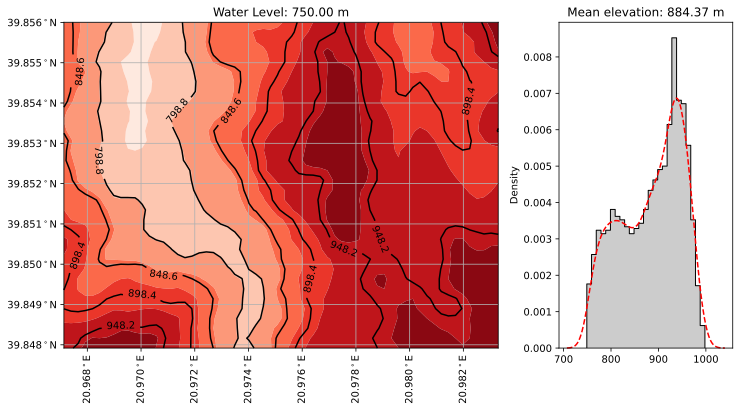

In [5]:
play = ipywidgets.Play(value=700, min=750, max=940, step=1, interval=500, description="Press play", disabled=False)

interact(contour_plt, water_level = play);